In [1]:
import os
import re
import numpy as np
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
from tensorflow import keras
import datetime
import warnings
from keras.preprocessing import sequence
import pprint

warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
df0=pd.read_csv('proccesed_data.csv')
df1=df0.copy()
#df0

In [3]:
df1=df0[['index','d_rel','v_rel','v_host']]
#df1.head()
#df1.info()

### Adding the timesteps

In [4]:
len_list=len(df1['d_rel'])
j=np.linspace(0,len_list,len_list,endpoint=False)
j=list(j/10)
df1['time']=j

## Multivariate Multi-Step Time-Series Forecasting

In [5]:
features_considered = df1.columns.tolist()
#features_considered = df1.drop(columns='time').columns.tolist()
df = df1[features_considered]
df.index = df1['time']
df.head()

,index,d_rel,v_rel,v_host,time
time,,,,,
0.0,0,39.889924,1.63,8.99,0.0
0.1,0,39.464712,1.67,8.99,0.1
0.2,0,39.546303,1.66,8.99,0.2
0.3,0,39.623756,1.51,8.99,0.3
0.4,0,39.844351,2.70,7.55,0.4


In [6]:
thrhd_val = 100

ind_array = np.bincount(df['index'])>thrhd_val
#print('ind_array',ind_array)
ind_fltrd = ind_array.astype(int)*df['index'].unique()
#print('ind_fltrd',ind_fltrd)

ind_fltrd_zero = ind_fltrd[ind_fltrd != 0]

df_fltrd = pd.DataFrame(columns=[])
for i in range(len(ind_fltrd_zero)):   
    df_fltrd = pd.concat([df_fltrd,df[ df['index'] == ind_fltrd_zero[i] ]],ignore_index=True).reset_index(drop=True)
print('df_flrt',df_fltrd['index'].unique())
print(df_fltrd)

df_flrt [  1   3   4   5   6   7   8   9  10  11  12  13  14  16  18  20  22  23
  24  27  28  29  30  31  34  35  37  38  41  42  46  47  48  50  52  53
  54  55  57  61  63  64  65  66  68  72  74  77  78  79  81  82  83  85
  86  88  89  90  92  93  96  98  99 100 101 102 103 104 106 107 108 110
 111 112 113 116 117 118 119 120 121 122 125 126 127 128 130 132 133 134
 136 138 141 142 144 148 149 150 151 153 157 158 159 160 162 164 166 172
 173 174 175 176 180 181 182 183 185 186 187 188 189 192 193 195 196 197
 198 199 201 202 203 204 205 207 210 211 212 214 215 216 218 219 220 223
 224 226 227]
       index       d_rel  v_rel  v_host    time
0          1   54.726225   7.59   39.41    41.4
1          1   55.425753   7.60   39.41    41.5
2          1   56.127418   7.63   39.41    41.6
3          1   56.680961   7.65   39.41    41.7
4          1   57.555903   8.10   38.96    41.8
...      ...         ...    ...     ...     ...
39270    227  117.189627   5.05   19.48  4328.5
39271    2

## Preprocessing: Train-test split

In [7]:
train_size = int(len(df_fltrd) * 0.6/thrhd_val)*thrhd_val
test_size = len(df_fltrd) - train_size
train, test = df_fltrd.iloc[0:train_size], df_fltrd.iloc[train_size:len(df_fltrd)]
print(train.shape, test.shape)

#pd.DataFrame('index':)
train_index_list = train['index'].unique()
print(train_index_list)


(23500, 5) (15775, 5)
[  1   3   4   5   6   7   8   9  10  11  12  13  14  16  18  20  22  23
  24  27  28  29  30  31  34  35  37  38  41  42  46  47  48  50  52  53
  54  55  57  61  63  64  65  66  68  72  74  77  78  79  81  82  83  85
  86  88  89  90  92  93  96  98  99 100 101 102 103 104 106 107 108 110
 111 112 113 116 117 118 119 120 121 122 125 126 127 128 130]


## batch sorting

In [8]:
# do bincount
train_seq_len = np.bincount(train['index'])
test_seq_len = np.bincount(test['index'])

print('Train Seq Length',train_seq_len.astype(int))
print('Test Seq Length',test_seq_len.astype(int))
#ind_fltrd = train_seq_len.astype(int)*train['index'].unique()


# do argsort on bincount array
sorted_index_tr = np.argsort(train_seq_len)
sorted_index_ts = np.argsort(test_seq_len)

inv_sorted_index_tr = sorted_index_tr[::-1]
inv_sorted_index_ts = sorted_index_ts[::-1]
                               
nzero_elem_num_tr = len(train_seq_len[train_seq_len != 0])
nzero_elem_num_ts = len(test_seq_len[test_seq_len != 0])

inv_sorted_index_fltrd_tr = inv_sorted_index_tr[0:nzero_elem_num_tr]
inv_sorted_index_fltrd_ts = inv_sorted_index_ts[0:nzero_elem_num_ts]

print('inversed filtered index train:',inv_sorted_index_fltrd_tr)
print('inversed filtered index test:',inv_sorted_index_fltrd_ts)

# then based on the argsort array elements resort the train df to batch data groups, resorting code is avalable


train_sorted = pd.DataFrame()
test_sorted = pd.DataFrame()

for i in range(len(inv_sorted_index_fltrd_tr)):   
    train_sorted = pd.concat([train_sorted,train[ train['index'] == inv_sorted_index_fltrd_tr[i] ]],ignore_index=True).reset_index(drop=True)

for i in range(len(inv_sorted_index_fltrd_ts)):   
    test_sorted = pd.concat([test_sorted,test[ test['index'] == inv_sorted_index_fltrd_ts[i] ]],ignore_index=True).reset_index(drop=True)

train_sorted.head()
test_sorted.head()

# question, how to feed batch data group to model?
# ans: turn off shuffle

train_lengths = np.sort(train_seq_len)[::-1]
test_lengths = np.sort(test_seq_len)[::-1]


Train Seq Length [  0 106   0 383 978 285 297 441 408 244 468 158 185 178 269   0 225   0
 183   0 471   0 107 407 236   0   0 136 146 315 131 170   0   0 234 222
   0 180 339   0   0 147 340   0   0   0 275 187 343   0 406   0 208 366
 209 537   0 307   0   0   0 101   0 202 790 155 148   0 135   0   0   0
 130   0 210   0   0 131 108 126   0 311 201 454   0 482 229   0 227 101
 149   0 111 353   0   0 244   0 225 405 311 110 285 151 212   0 396 738
 300   0 137 178 181 270   0   0 312 188 115 556 583 113 153   0   0 128
 329 270 264   0 265]
Test Seq Length [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

In [9]:
#train_seq_len.sort(reverse=True)
print(np.sort(train_seq_len)[::-1])

[978 790 738 583 556 537 482 471 468 454 441 408 407 406 405 396 383 366
 353 343 340 339 329 315 312 311 311 307 300 297 285 285 275 270 270 269
 265 264 244 244 236 234 229 227 225 225 222 212 210 209 208 202 201 188
 187 185 183 181 180 178 178 170 158 155 153 151 149 148 147 146 137 136
 135 131 131 130 128 126 115 113 111 110 108 107 106 101 101   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0]


In [10]:
f_columns = ['d_rel','v_rel']
f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train_sorted[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train_sorted[['v_host']])

train_sorted.loc[:, f_columns] = f_transformer.transform(train_sorted[f_columns].to_numpy())
test_sorted.loc[:, f_columns] = f_transformer.transform( test_sorted[f_columns].to_numpy())

train_sorted['v_host'] = cnt_transformer.transform(train_sorted[['v_host']])
test_sorted['v_host'] = cnt_transformer.transform(test_sorted[['v_host']])


print(train_sorted['d_rel'])
print(test_sorted['d_rel'].iloc[430:480])

0       -0.166762
1       -0.161131
2       -0.156029
3       -0.149679
4       -0.141467
           ...   
23495    0.089908
23496    0.062567
23497    0.032739
23498    0.004601
23499   -0.018905
Name: d_rel, Length: 23500, dtype: float64
430   -0.110234
431   -0.127908
432   -0.145113
433   -0.162381
434   -0.177335
435   -0.188819
436   -0.198520
437   -0.207805
438   -0.217818
439   -0.230093
440   -0.243425
441   -0.255747
442   -0.269622
443   -0.284730
444   -0.294912
445   -0.302605
446   -0.307036
447   -0.307697
448   -0.309493
449   -0.311268
450   -0.313049
451   -0.314827
452   -0.316622
453   -0.318382
454   -0.320162
455   -0.321937
456   -0.323732
457   -0.325510
458   -0.327287
459   -0.329067
460   -0.330863
461   -0.332637
462   -0.334414
463   -0.336194
464   -0.337989
465   -0.339766
466   -0.341540
467   -0.343317
468   -0.345097
469   -0.346873
470   -0.348650
471   -0.350445
472   -0.352221
473   -0.353998
474   -0.355774
475   -0.357569
476   -0.359345
477   -

In [11]:
train_index_list = train_sorted['index'].unique()
test_index_list = test_sorted['index'].unique()

print(train_sorted['index'].unique())
print(test_sorted['index'].unique())
#print((np.bincount(train['index'])))

[  4  64 107 120 119  55  85  20  10  83   7   8  23  50  99 106   3  53
  93  48  42  38 126  29 116  81 100  57 108   6   5 102  46 113 127  14
 130 128  96   9  24  34  86  88  98  16  35 104  74  54  52  63  82 117
  47  12  18 112  37 111  13  31  11  65 122 103  90  66  41  28 110  27
  68  77  30  72 125  79 118 121  92 101  78  22   1  89  61]
[187 205 220 186 132 212 204 138 195 227 153 192 223 185 215 207 196 188
 175 218 162 224 166 141 144 130 133 160 214 199 197 226 202 176 201 203
 136 159 183 182 172 149 189 193 158 173 181 164 157 174 150 219 134 216
 198 210 180 142 148 211 151]


## Revised Version

In [12]:
batch_size=4

train_index_list = train_sorted['index'].unique()
test_index_list = test_sorted['index'].unique()

padding_maxlen = 150 #max(np.bincount(train['index']))
padding_maxlen_tr = 150
print(train_index_list)
print(len(train_index_list))

seq_number_tr = len(train_index_list) #train_index_list[-1]-train_index_list[0]
seq_number_ts = len(test_index_list)  #test_index_list[-1]-test_index_list[0]


train_inp_tensor = np.array
train_out_tensor = np.array

test_inp_tensor = np.array
test_out_tensor = np.array

train_fltrd = train_sorted.filter(items=['index','d_rel','v_rel','v_host'])
test_fltrd  = test_sorted.filter (items=['index','d_rel','v_rel','v_host'])

for i in range(0,seq_number_tr):   



    train_sngl_scnro = train_fltrd[train_fltrd['index']==train_index_list[i]].reset_index(drop=True)


    # get the length of the first seq of each batch as the padding_maxlen of that batch
    #if i%batch_size==0:
    #    padding_maxlen_tr   = len(train_sngl_scnro) -20 

    
    train_input_col1 = train_sngl_scnro.filter(items=['d_rel'])   
    train_input_col2 = train_sngl_scnro.filter(items=['v_rel']) 
    train_output_col = train_sngl_scnro.filter(items=['v_host']) 

    train_input_array1 =sequence.pad_sequences([tuple(train_input_col1.values.tolist())],maxlen=padding_maxlen_tr, dtype='float32',padding='post',value=250)
    train_input_array2 =sequence.pad_sequences([tuple(train_input_col2.values.tolist())],maxlen=padding_maxlen_tr, dtype='float32',padding='post',value=0)
    train_output_array =sequence.pad_sequences([tuple(train_output_col.values.tolist())],maxlen=padding_maxlen_tr, dtype='float32',padding='post',value=train_output_col['v_host'].iloc[-1]) ############train_output_col[-1]?????????????????????????##########

    inp_array1 = [float(str(train_input_array1[0][i])[1:-1]) for i in range(padding_maxlen_tr) ]
    inp_array2 = [float(str(train_input_array2[0][i])[1:-1]) for i in range(padding_maxlen_tr) ]
    out_array = [float(str(train_output_array[0][i])[1:-1]) for i in range(padding_maxlen_tr) ]

    df_input = pd.DataFrame()
    df_output = pd.DataFrame()

    df_input.insert(0, "d_rel_padded" , inp_array1, True) 
    df_input.insert(1, "v_rel_padded", inp_array2, True) 
    inp_df = df_input.filter(items=['d_rel_padded','v_rel_padded'])

    df_output.insert(0, "v_host_padded", out_array, True) 
    out_df = df_output.filter(items=['v_host_padded']) 

    train_input_array =sequence.pad_sequences([tuple(inp_df.values.tolist())],maxlen=padding_maxlen_tr, dtype='float32',padding='post',value=1)
    train_output_array =sequence.pad_sequences([tuple(out_df.values.tolist())],maxlen=padding_maxlen_tr, dtype='float32',padding='post',value=1) 
    
    #print('SEE',train_output_array.shape)
    if i ==0:
        train_inp_tensor = train_input_array
        train_out_tensor = train_output_array
    else:
        train_inp_tensor = np.vstack([train_inp_tensor , train_input_array])
        train_out_tensor = np.vstack([train_out_tensor , train_output_array])



for i in range(0,seq_number_ts):

   
    test_fltrd  = test.filter (items=['index','d_rel','v_rel','v_host'])
    test_sngl_scnro  = test_fltrd[test_fltrd['index']==test_index_list[i]].reset_index(drop=True)
    
    test_input_col1 = test_sngl_scnro.filter(items=['d_rel'])   
    test_input_col2 = test_sngl_scnro.filter(items=['v_rel']) 
    test_output_col = test_sngl_scnro.filter(items=['v_host']) 


    test_input_array1 =sequence.pad_sequences([tuple(test_input_col1.values.tolist())],maxlen=padding_maxlen, dtype='float32',padding='post',value=250)
    test_input_array2 =sequence.pad_sequences([tuple(test_input_col2.values.tolist())],maxlen=padding_maxlen, dtype='float32',padding='post',value=0)
    test_output_array =sequence.pad_sequences([tuple(test_output_col.values.tolist())],maxlen=padding_maxlen, dtype='float32',padding='post',value=test_output_col['v_host'].iloc[-1])########test_output_col[-1]?????????##########

    inp_array_ts1 = [float(str(test_input_array1[0][i])[1:-1]) for i in range(padding_maxlen) ]
    inp_array_ts2 = [float(str(test_input_array2[0][i])[1:-1]) for i in range(padding_maxlen) ]
    out_array_ts =  [float(str(test_output_array[0][i])[1:-1]) for i in range(padding_maxlen) ]

    df_input_ts = pd.DataFrame()
    df_output_ts = pd.DataFrame()

    df_input_ts.insert(0, "d_rel_padded" , inp_array_ts1, True) 
    df_input_ts.insert(1, "v_rel_padded", inp_array_ts2, True) 
    inp_df_ts = df_input_ts.filter(items=['d_rel_padded','v_rel_padded'])

    df_output_ts.insert(0, "v_host_padded", out_array_ts, True) 
    out_df_ts = df_output_ts.filter(items=['v_host_padded']) 

    test_input_array =sequence.pad_sequences([tuple(inp_df_ts.values.tolist())],maxlen=padding_maxlen, dtype='float32',padding='post',value=1)
    test_output_array =sequence.pad_sequences([tuple(out_df_ts.values.tolist())],maxlen=padding_maxlen, dtype='float32',padding='post',value=1) 
    
    #print('SEE',train_output_array.shape)
    if i ==0:
        test_inp_tensor = test_input_array
        test_out_tensor = test_output_array
    else:    
        test_inp_tensor = np.vstack([test_inp_tensor , test_input_array])
        test_out_tensor = np.vstack([test_out_tensor , test_output_array])

train_inp_data = train_inp_tensor.reshape(seq_number_tr,padding_maxlen,2)
print('train_inp_data size :' , train_inp_tensor.shape)
train_out_data = train_out_tensor.reshape(seq_number_tr,padding_maxlen,1)
print('train_out_data size:' ,  train_out_data.shape)

test_inp_data = test_inp_tensor.reshape(seq_number_ts,padding_maxlen,2)
print('test_inp_data size :' , test_inp_data.shape)
test_out_data = test_out_tensor.reshape(seq_number_ts,padding_maxlen,1)
print('test_out_data size:' ,  test_out_data.shape)


[  4  64 107 120 119  55  85  20  10  83   7   8  23  50  99 106   3  53
  93  48  42  38 126  29 116  81 100  57 108   6   5 102  46 113 127  14
 130 128  96   9  24  34  86  88  98  16  35 104  74  54  52  63  82 117
  47  12  18 112  37 111  13  31  11  65 122 103  90  66  41  28 110  27
  68  77  30  72 125  79 118 121  92 101  78  22   1  89  61]
87
train_inp_data size : (87, 150, 2)
train_out_data size: (87, 150, 1)
test_inp_data size : (61, 150, 2)
test_out_data size: (61, 150, 1)


<Figure size 432x288 with 0 Axes>

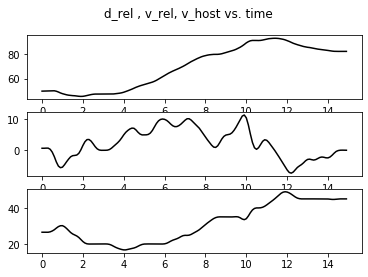

<Figure size 1440x720 with 0 Axes>

In [13]:
sample_num = 11 # from 0 to 26

data2show_drel  = test_inp_data[sample_num,:,0]  #index22 may production ACC
data2show_vrel  = test_inp_data[sample_num,:,1]
data2show_vhost = test_out_data[sample_num,:,0]
time_sample = range(len(data2show_drel))
time_vector = [0.1*i for i in time_sample]
plt.figure()
fig, (ax1,ax2,ax3) = plt.subplots(3)
plt.figure(figsize=(20,10))
fig.suptitle('d_rel , v_rel, v_host vs. time')
ax1.plot(time_vector,data2show_drel,'k')
ax2.plot(time_vector,data2show_vrel,'k')
ax3.plot(time_vector,data2show_vhost,'k')
plt.show()

## Train Batch Generator Function

In [20]:
def train_batch_generator(batch_size=4):
    '''
    :param batch_size:
    :return:
    '''

    #Info ::  train_inp_data = train_inp_tensor.reshape(seq_number_tr,padding_maxlen,2)
    X_train = train_inp_data
    Y_train = train_out_data
    
    # generate a list of the length of training sequences (before padding)
    train_lengths = np.sort(train_seq_len)
    for j in range(0,len(train_lengths)):
        if  train_lengths[j]!=0:
            train_len.append(train_lengths[j])
        
    # seprate training input(X) and output(Y) from PADDED database for this specific batch
    # generate the wigth list for training sequenses used in this batch

    start_idx = 0
    while True:
        if not start_idx < len(train_len):
            start_idx = 0
        X = X_train[start_idx:(min(start_idx + batch_size, len(train_len))),
            0:train_len[min(start_idx + batch_size, len(train_len)) - 1],:]   
        Y = Y_train[start_idx:(min(start_idx + batch_size, len(train_len))),
            0:train_len[min(start_idx + batch_size, len(train_len)) - 1],:]

        W = []
        for idx in range(start_idx, (min(start_idx + batch_size, len(train_lengths)))):
            W.append([1 if l < train_len[idx] else 0 for l in
                      range(0, train_len[min(start_idx + batch_size, len(train_len)) - 1])])

        start_idx += batch_size
        #print('W ',W)
        print('size of X:',X.shape)

        yield X, Y, np.array(W)
    print(X.shape)

## Validation Batch Generator Function

In [27]:
def validation_batch_generator(batch_size=4):
    '''
    :param batch_size:
    :return:
    '''
        #Info ::  test_inp_data = test_inp_tensor.reshape(seq_number_tr,padding_maxlen,2)
    X_test = test_inp_data
    Y_test = test_out_data
    
    # generate a list of the length of testing sequences (before padding)
    
    test_lengths = np.sort(test_seq_len)
    test_len=[]
    for j in range(0,len(test_lengths)):
        if  test_lengths[j]!=0:
            test_len.append(test_lengths[j])
        
    # seprate testing input(X) and output(Y) from PADDED database for this specific batch
    # generate the wigth list for testing sequenses used in this batch

    start_idx = 0
    while True:
        if not start_idx < len(test_len):
            start_idx = 0
        X = X_test[start_idx:(min(start_idx + batch_size, len(test_len))),
            0:test_len[min(start_idx + batch_size, len(test_len)) - 1],:]   
        Y = Y_test[start_idx:(min(start_idx + batch_size, len(test_len))),
            0:test_len[min(start_idx + batch_size, len(test_len)) - 1],:]

        W = []
        for idx in range(start_idx, (min(start_idx + batch_size, len(test_lengths)))):
            W.append([1 if l < test_len[idx] else 0 for l in
                      range(0, test_len[min(start_idx + batch_size, len(test_len)) - 1])])

        start_idx += batch_size
        print('Size of Val X:', X.shape)
        yield X, Y, np.array(W)
    


## Validation Batch Generator For Test Function

In [24]:
def validation_batches_fortest(batchsize=4):
    '''
    :param batchsize:
    :return:
    '''
    test_lengths = [int(i) for i in FileUtility.load_list(
        'datasets/test_length.txt')]
    X_test = np.load('datasets/X_test_408.npy')
    Y_test = np.array(
        np.load('datasets/test_mat_Y.npy'))
    start_idx = 0
    while start_idx < len(test_lengths):
        X = X_test[start_idx:(min(start_idx + batchsize, len(test_lengths))),
            0:test_lengths[min(start_idx + batchsize, len(test_lengths)) - 1],0:1]
        Y = Y_test[start_idx:(min(start_idx + batchsize, len(test_lengths))),
            0:test_lengths[min(start_idx + batchsize, len(test_lengths)) - 1],0]
        W = []
        for idx in range(start_idx, (min(start_idx + batchsize, len(test_lengths)))):
            W.append([1 if l < test_lengths[idx] else 0 for l in
                      range(0, test_lengths[min(start_idx + batchsize, len(test_lengths)) - 1])])
        #print('W size',len(W))
        start_idx += batchsize
        yield X, Y, np.array(W)

In [16]:
train_lengths = np.sort(train_seq_len)
train_len=[]
for j in range(0,len(train_lengths)):
    if  train_lengths[j]!=0:
        train_len.append(train_lengths[j])


test_lengths = np.sort(test_seq_len)
test_len=[]
for j in range(0,len(test_lengths)):
 if  test_lengths[j]!=0:
    test_len.append(test_lengths[j])


X_test = test_inp_data
Y_test = test_out_data
start_idx=0
batch_size=4
X = X_test[start_idx:(min(start_idx + batch_size, len(test_len))),0:test_len[min(start_idx + batch_size, len(test_len)) - 1],:]   
Y = Y_test[start_idx:(min(start_idx + batch_size, len(test_len))),0:test_len[min(start_idx + batch_size, len(test_len)) - 1],:]

print(X.shape)
print(Y.shape)

print(len(train_len)+len(test_len))



(4, 110, 2)
(4, 110, 1)
148


In [18]:
model = keras.Sequential()
model.add(keras.layers.LSTM(120,input_shape=(4,2) )) ## DO IT  use drop out
model.add(keras.layers.Dense(1))
model.compile(loss="mse", optimizer = tf.keras.optimizers.SGD(lr=7e-4, momentum = 0.85),weighted_metrics=['accuracy'],
                  sample_weight_mode='temporal')  ### TO DO lr = 10^-3
#model.compile(loss='mean_squared_error', optimizer='adam')

(4, 20, 2)


In [32]:
    train_batch_size = 4
    test_batch_size  = 4
    epochs = 5
    

    train_lengths = np.sort(train_seq_len)
    train_len=[]
    for j in range(0,len(train_lengths)):
        if  train_lengths[j]!=0:
            train_len.append(train_lengths[j])

    test_lengths = np.sort(test_seq_len)
    test_len=[]
    for j in range(0,len(test_lengths)):
        if  test_lengths[j]!=0:
            test_len.append(test_lengths[j])

    #checkpoint = ModelCheckpoint(filepath, monitor='val_weighted_acc', verbose=1, save_best_only=True, mode='max',period=1)
    #earlystopping = EarlyStopping(monitor='val_weighted_acc', min_delta=0, patience=patience, verbose=0, mode='max',baseline=None)
    #callbacks_list = [earlystopping]

    # calculate the sizes
    steps_per_epoch = len(train_len) / train_batch_size if len(train_len) % train_batch_size == 0 else int(len(train_len) / train_batch_size) + 1
    validation_steps = int(len(test_len) / test_batch_size) if len(test_len) % test_batch_size == 0 else int(len(test_len) / test_batch_size) + 1
    #print('step train:' , steps_per_epoch)
    #print('step test:' , validation_steps)
    validation_steps = 1
    # feed model
    h = model.fit_generator(train_batch_generator(train_batch_size), steps_per_epoch=steps_per_epoch,
    validation_data=validation_batch_generator(test_batch_size),validation_steps=validation_steps,shuffle=False, epochs=epochs, verbose=0)

size of X: (4, 107, 2)
  ...
    to  
  ['...']
Size of Val X: (4, 110, 2)
  ...
    to  
  ['...']
size of X: (4, 113, 2)
size of X: (4, 130, 2)
size of X: (4, 136, 2)
size of X: (4, 148, 2)
size of X: (4, 150, 2)


InvalidArgumentError:  Can not squeeze dim[1], expected a dimension of 1, got 107
	 [[node metrics/accuracy/Squeeze (defined at <ipython-input-19-c8eb7ad8c8c8>:30) ]] [Op:__inference_distributed_function_4041]

Function call stack:
distributed_function


In [ ]:

#print(validation_steps)
test=tf.slice(X, [0, 10, 0], [4, 20, 2])
#test = slice_tensor(4, 10, 2, name='skipgramembd')(X)
print(test.shape)

In [97]:
history = model.fit(
    train_inp_data , train_out_data,
    epochs=120,
    batch_size=4,
    #validation_split=0.1,
    validation_data=(test_inp_data, test_out_data)
    #shuffle=False
)
model.summary()

Train on 87 samples, validate on 61 samples
Epoch 1/120
87/87 [==============================] - 8s 94ms/sample - loss: 0.4521 - val_loss: 774.6339
Epoch 2/120
87/87 [==============================] - 4s 43ms/sample - loss: 0.3624 - val_loss: 767.5292
Epoch 3/120
87/87 [==============================] - 4s 41ms/sample - loss: 0.3505 - val_loss: 771.1076
Epoch 4/120
87/87 [==============================] - 4s 41ms/sample - loss: 0.3509 - val_loss: 771.8027
Epoch 5/120
87/87 [==============================] - 4s 43ms/sample - loss: 0.3440 - val_loss: 775.1554
Epoch 6/120
87/87 [==============================] - 4s 49ms/sample - loss: 0.3342 - val_loss: 775.4478
Epoch 7/120
87/87 [==============================] - 4s 48ms/sample - loss: 0.3327 - val_loss: 775.6391
Epoch 8/120
87/87 [==============================] - 5s 53ms/sample - loss: 0.3309 - val_loss: 777.0755
Epoch 9/120
87/87 [==============================] - 4s 51ms/sample - loss: 0.3265 - val_loss: 777.8251
Epoch 10/120
87/87 [

KeyboardInterrupt: 

In [387]:
window_time = 50
sample_num = 22 # from 0 to 26
for i in range(test_inp_data.shape[1]-window_time):
    y_pred[i]=model.predict(test_inp_data[sample_num,0:i+window_time,:])

#print(test_inp_data.shape)
#print(y_pred.shape)


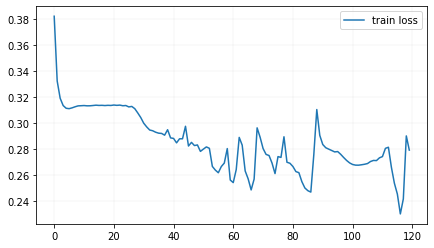

In [66]:
plt.figure(figsize=(7,4))
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.legend()  
plt.grid(color='gray', linestyle='--', linewidth=0.1)

<Figure size 432x288 with 0 Axes>

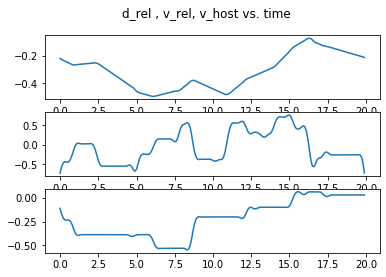

<Figure size 2880x1440 with 0 Axes>

No handles with labels found to put in legend.


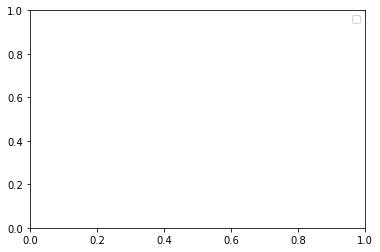

In [369]:
data2show_drel  = test_inp_data[sample_num,window_time:end,0]  #index22 may production ACC
data2show_vrel  = test_inp_data[sample_num,window_time:end,1]
data2show_vhost = y_pred
#res2show_vhost = y_pred[22,:,0]

time_sample = range(len(data2show))
time_vector = [0.1*i for i in time_sample]
plt.figure()
fig, (ax1,ax2,ax3) = plt.subplots(3)
plt.figure(figsize=(40,20))
fig.suptitle('d_rel , v_rel, v_host vs. time')
ax1.plot(time_vector,data2show_drel,label='d_rel')
ax2.plot(time_vector,data2show_vrel,label='v_rel')
ax3.plot(time_vector,data2show_vhost,label='v_host')
#ax3.plot(time_vector,data2show_vhost,label='v_host_pred')
plt.show()
plt.legend()

## ploting a sample of results

In [ ]:
f = plt.figure(figsize=(15,9))
plt.plot(y_test_inv.flatten()[200:270],marker='.',label='true')
plt.plot(y_pred_inv.flatten()[200:270],'r',label='predicted')
plt.xlabel('Time [Deci-Second]')
plt.ylabel('Host Vehicle Speed [Miles/hour]')
plt.legend()

In [ ]:
x_test_inv=cnt_transformer.inverse_transform(test_inp_data.reshape(1,-1))
y_test_inv=cnt_transformer.inverse_transform(test_out_data.reshape(1,-1))
y_pred_inv=cnt_transformer.inverse_transform(y_pred)

print(x_test_inv.shape)

In [278]:
def create_dataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [281]:
time_steps = 10  ####??????????Do do we have lead in training or not???

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train_inp_data, train_out_data, time_steps)
X_test, y_test = create_dataset(test, test.v_host, time_steps)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

test.head()

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

(28561, 10, 5) (28561,)
(14709, 10, 5) (14709,)


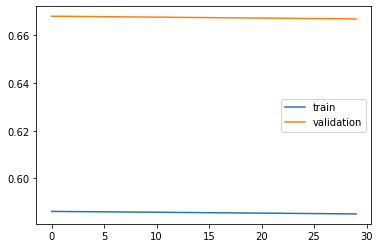

ValueError: Input 0 is incompatible with layer sequential_1: expected shape=(None, None, 2), found shape=[None, 10, 5]

In [ ]:
y_train_inv=cnt_transformer.inverse_transform(y_train.reshape(1,-1))
y_test_inv=cnt_transformer.inverse_transform(y_test.reshape(1,-1))
y_pred_inv=cnt_transformer.inverse_transform(y_pred)

In [ ]:
f = plt.figure(figsize=(15,9))
plt.plot(y_test_inv.flatten(),marker='.',label='true')
plt.plot(y_pred_inv.flatten(),'r',label='predicted')
plt.xlabel('Time [Deci-Second]')
plt.ylabel('Host Vehicle Speed [Miles/hour]')
plt.legend();

In [ ]:
f = plt.figure(figsize=(15,9))
plt.plot(y_test_inv.flatten()[200:270],marker='.',label='true')
plt.plot(y_pred_inv.flatten()[200:270],'r',label='predicted')
plt.xlabel('Time [Deci-Second]')
plt.ylabel('Host Vehicle Speed [Miles/hour]')
plt.legend();

### APPENDIX: how to do padding

In [258]:
train_single_col_val = train_single_col['d_rel'][0:20].values
print(train_single_col_val)
mat_out1 =  np.asarray(train_single_col_val)
#print(mat_out1)

outt = tuple(mat_out1.tolist())
#print([outt])
x_train4 = sequence.pad_sequences([tuple(mat_out1.tolist())],maxlen=50, dtype='float32',padding='post')
print(x_train4)

[-0.17894069 -0.18229132 -0.18551764 -0.18888987 -0.19223892 -0.19561006
 -0.19895805 -0.2023104  -0.20567988 -0.20902622 -0.21239457 -0.21576235
 -0.21910699 -0.2224736  -0.22579935 -0.22916956 -0.23253435 -0.23587603
 -0.23811794 -0.24438204]
[[-0.17894068 -0.18229131 -0.18551764 -0.18888986 -0.19223891 -0.19561006
  -0.19895805 -0.2023104  -0.20567988 -0.20902622 -0.21239458 -0.21576235
  -0.21910699 -0.2224736  -0.22579935 -0.22916956 -0.23253435 -0.23587602
  -0.23811795 -0.24438204  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]]


In [ ]:
 from sklearn.preprocessing import StandardScaler
>>> scaler = StandardScaler().fit(x_train2)
>>> standardized_X = scaler.transform(x_train2)
>>> standardized_X_test = scaler.transform(x_test2)

In [264]:


TestArr1 = np.array([[(1,2,3),(3,4,5),(1,2,3),(1,2,3)],[(1,2,3),(1,2,3),(1,2,3),(3,4,5)],[(1,2,3),(3,4,5),(1,2,3),(1,2,3)],[(1,2,3),(1,2,3),(1,2,3),(3,4,5)]])
print(TestArr1.shape)
TestArr2 = np.array([[(1,2,3),(3,4,5),(1,2,3),(1,2,3)],[(1,2,3),(1,2,3),(1,2,3),(3,4,5)]])
#TestArr1.reshape(1,3,2)
print(TestArr2.shape)
#TestArr2.reshape(2,4,3)
print(TestArr2.shape)

Net = np.vstack([TestArr1,TestArr2]) 

print(Net.shape)

(4, 4, 3)
(1, 4, 3)
(1, 4, 3)
(5, 4, 3)


In [ ]:
model = keras.Sequential([
    #keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=1), input_shape = [None]),
    #keras.layers.Bidirectional(keras.layers.LSTM(32), return_sequences=True),
    #keras.layers.Embedding(190,20),
    keras.layers.Bidirectional(keras.layers.LSTM(2), input_shape = (None,1)),
    keras.layers.Dense(1),
    #keras.layers.Lambda(lambda x: x*1.0)
])
model.compile(loss="mse", optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum = 0.9))

In [ ]:
train_index_list = train['index'].unique()
padding_maxlen = max(np.bincount(train['index']))
#seq_number = train_index_list[-1]
seq_number = 12
train_tensor = np.array

for i in range(train_index_list[0],train_index_list[0]+2):   
    train_fltrd = train.filter(items=['index','d_rel','v_host','v_rel'])
    train_sngl_scnro = train_fltrd[train_fltrd['index']==train_index_list[i]].reset_index(drop=True)
    
    train_input_col1 = train_sngl_scnro.filter(items=['d_rel','d_rel'])   
    train_input_vec1 =sequence.pad_sequences([tuple(train_input_col1.values.tolist())],maxlen=padding_maxlen, dtype='float32',padding='post',value=1000.0)
    
    
    train_input_col2 = train_single_col.filter(items=['v_host','v_host'])  
    #print(train_input_col2['v_host'].values[-1]) 
    train_input_vec2 =sequence.pad_sequences([tuple(train_input_col2.values.tolist())],maxlen=padding_maxlen, dtype='float32',padding='post',value=train_input_col2['v_host'].values[-1])



    print('before:',train_input_vec1.shape) 
    #tuple(train_input_vec1).reshape(padding_maxlen,1,2)
    #train_input_vec2.reshape(padding_maxlen,1,1)
    print('after:',train_input_vec1.shape) 

    train_input_array = train_input_vec1    
    #train_input_array = np.vstack([train_input_vec1 , train_input_vec2]) # should be (1,987,2)
    
    print('before:',train_input_array.shape) # should be (1,987,2)
    #train_input_array.reshape(1,padding_maxlen,4)
    print('after:',train_input_array.shape)



    
    if i ==train_index_list[0]:
        train_tensor = train_input_array
    else:
        print('iter')
        train_tensor = np.vstack([train_tensor , train_input_array])
    
    print('tensor shape:',train_tensor.shape)

train_tensor.reshape(2,padding_maxlen,2)
print('train_tensor size :' , train_tensor.shape)
#y_tensor = train_tensor[:,:,1].reshape(seq_number,padding_maxlen,1)
#print('y_tensor size:' ,  y_tensor.shape)

In [ ]:
model.fit(train_inp_data , train_out_data, epochs = 1 , batch_size=2 )

## Original

In [ ]:
train_index_list = train['index'].unique()
padding_maxlen = max(np.bincount(train['index']))
seq_number = train_index_list[-1]
train_tensor = np.array

for i in range(train_index_list[0],seq_number):   
    train_single_col = train.filter(items=['index','d_rel','v_rel'])
    train_single_col= train_single_col[train_single_col['index']==train_index_list[i]].reset_index(drop=True)
    
    train_input_col = train_single_col.filter(items=['d_rel','v_rel'])   
    train_input_array =sequence.pad_sequences([tuple(train_input_col.values.tolist())],maxlen=padding_maxlen, dtype='float32',padding='post',value=1)
    
    train_input_array.reshape(padding_maxlen,1,2)
    #print(train_input_array.shape)
    
    if i ==train_index_list[0]:
        train_tensor = train_input_array
    else:
        train_tensor = np.vstack([train_tensor , train_input_array])
    
    

train_tensor.reshape(padding_maxlen,seq_number,2)
print('train_tensor size :' , train_tensor.shape)
y_tensor = train_tensor[:,:,1].reshape(seq_number,padding_maxlen,1)
print('y_tensor size:' ,  y_tensor.shape)